In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE
import joblib
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
print("Loading data...")
credit_data = pd.read_csv("UCI_Credit_Card.csv")

# Basic information about the dataset
print("\nBasic Information:")
print(f"Shape of dataset: {credit_data.shape}")
print("\nFirst few rows:")
print(credit_data.head())

# Check for missing values
print("\nMissing values in each column:")
print(credit_data.isnull().sum())


Loading data...

Basic Information:
Shape of dataset: (30000, 25)

First few rows:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   

In [2]:
# ==== Data Preprocessing ====
print("\n==== Data Preprocessing ====")

# Drop ID column (not useful for modeling)
credit_data = credit_data.drop('ID', axis=1)

# Check education and marriage for unusual values
print("\nUnique values in EDUCATION:", credit_data['EDUCATION'].unique())
print("Unique values in MARRIAGE:", credit_data['MARRIAGE'].unique())

# Fix education and marriage variables:
credit_data['EDUCATION'] = credit_data['EDUCATION'].map(lambda x: 4 if x in [0, 5, 6] else x)
credit_data['MARRIAGE'] = credit_data['MARRIAGE'].map(lambda x: 3 if x == 0 else x)

print("\nAfter cleaning:")
print("Unique values in EDUCATION:", credit_data['EDUCATION'].unique())
print("Unique values in MARRIAGE:", credit_data['MARRIAGE'].unique())

# Feature and target variables
X = credit_data.drop('default.payment.next.month', axis=1)
y = credit_data['default.payment.next.month']

# Split data into training, validation and test sets (60%, 20%, 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['LIMIT_BAL', 'AGE'] + [col for col in X.columns if col.startswith('BILL_') or col.startswith('PAY_AMT')]
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Define the CV strategy - use stratified k-fold to handle class imbalance
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate and report model performance
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, selected_features=None):
    """Evaluate model performance with multiple metrics and visualizations"""
    start_time = time.time()
    
    # Use selected features if provided
    X_train_use = X_train[selected_features] if selected_features is not None else X_train
    X_val_use = X_val[selected_features] if selected_features is not None else X_val
    
    # Cross-validation on training data
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=cv_strategy, scoring='roc_auc')
    
    # Fit the model on training data
    model.fit(X_train_use, y_train)
    
    # Predictions on validation data
    y_pred_proba = model.predict_proba(X_val_use)[:, 1]
    y_pred = model.predict(X_val_use)
    
    # Compute metrics
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)
    
    # Classification report and confusion matrix
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    # Training time
    training_time = time.time() - start_time
    
    print(f"\n{model_name} Results:")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"CV ROC-AUC Scores: {cv_scores}")
    print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Validation Avg Precision: {avg_precision:.4f}")
    
    print("\nClassification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()
    
    # If model has coefficients, plot feature importance
    if hasattr(model, 'coef_'):
        features = selected_features if selected_features is not None else X_train.columns
        coef = model.coef_[0]
        indices = np.argsort(np.abs(coef))
        sorted_features = np.array(features)[indices]
        sorted_coef = coef[indices]
        
        plt.figure(figsize=(12, 10))
        plt.barh(range(len(sorted_coef)), sorted_coef)
        plt.yticks(range(len(sorted_coef)), sorted_features)
        plt.xlabel('Coefficient magnitude')
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
    
    return avg_precision, roc_auc, model

# Function to tune hyperparameters
def tune_hyperparameters(model, param_grid, X_train, y_train, cv=None, scoring='roc_auc'):
    """Tune hyperparameters using grid search and cross-validation"""
    if cv is None:
        cv = cv_strategy
        
    grid_search = GridSearchCV(
        model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_




==== Data Preprocessing ====

Unique values in EDUCATION: [2 1 3 5 4 6 0]
Unique values in MARRIAGE: [1 2 3 0]

After cleaning:
Unique values in EDUCATION: [2 1 3 4]
Unique values in MARRIAGE: [1 2 3]
Training set shape: (18000, 23)
Validation set shape: (6000, 23)
Test set shape: (6000, 23)



==== Model Building and Evaluation ====

Training baseline Logistic Regression...

Baseline Logistic Regression Results:
Training time: 0.21 seconds
CV ROC-AUC Scores: [0.74433195 0.72314923 0.71371748 0.71553735 0.7286708 ]
Mean CV ROC-AUC: 0.7251 (±0.0110)
Validation ROC-AUC: 0.7030
Validation Avg Precision: 0.4785

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4673
           1       0.66      0.23      0.34      1327

    accuracy                           0.80      6000
   macro avg       0.74      0.60      0.61      6000
weighted avg       0.78      0.80      0.76      6000


Confusion Matrix:
[[4519  154]
 [1027  300]]


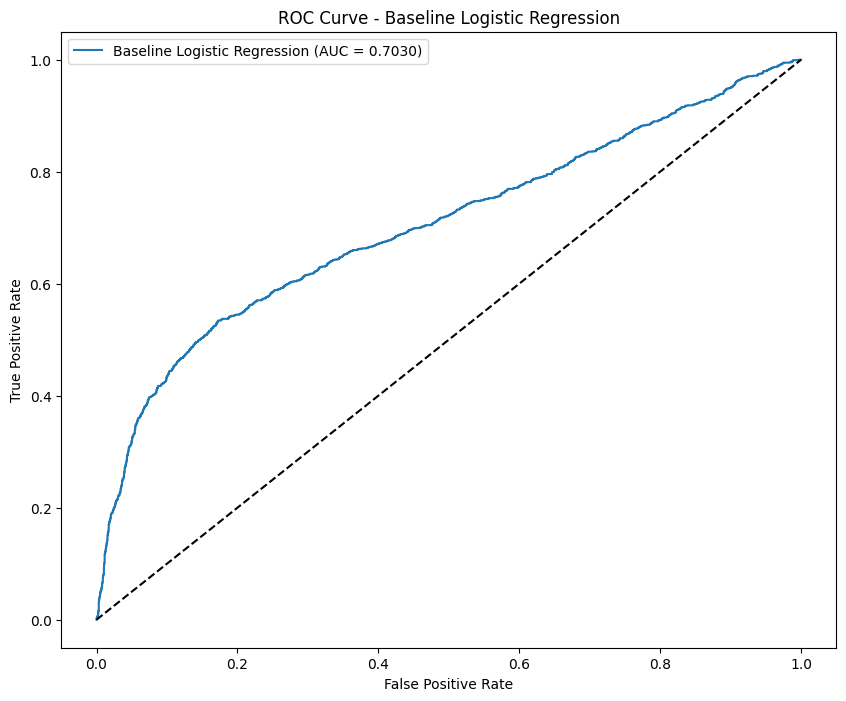

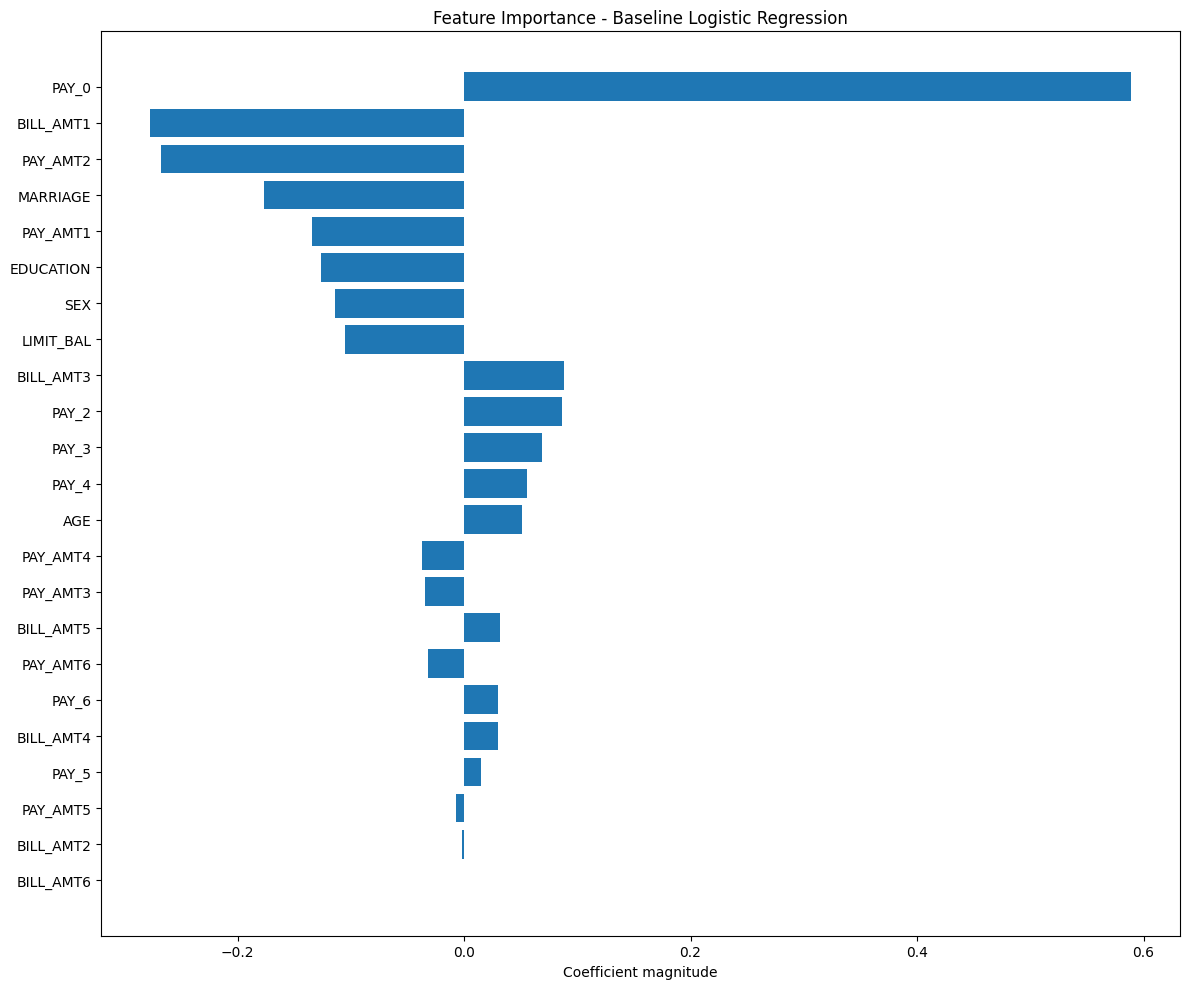


Training Ridge Logistic Regression with Hyperparameter Tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 10.0, 'class_weight': 'balanced'}
Best CV score: 0.7255

Ridge Logistic Regression (Tuned) Results:
Training time: 0.21 seconds
CV ROC-AUC Scores: [0.74528043 0.72342969 0.71458218 0.71502034 0.72930777]
Mean CV ROC-AUC: 0.7255 (±0.0113)
Validation ROC-AUC: 0.7034
Validation Avg Precision: 0.4759

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      4673
           1       0.37      0.61      0.46      1327

    accuracy                           0.69      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.69      0.71      6000


Confusion Matrix:
[[3330 1343]
 [ 523  804]]


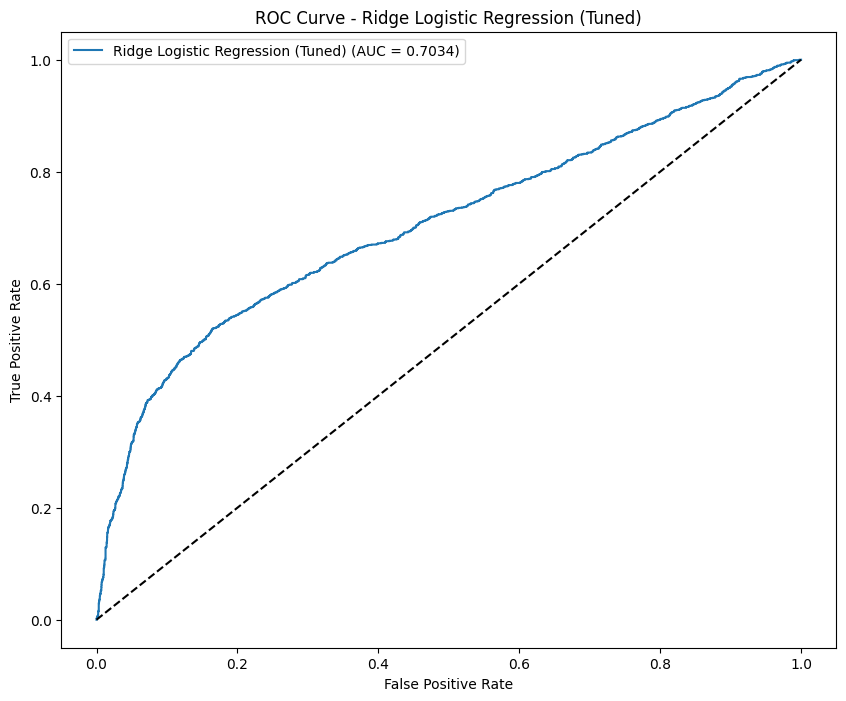

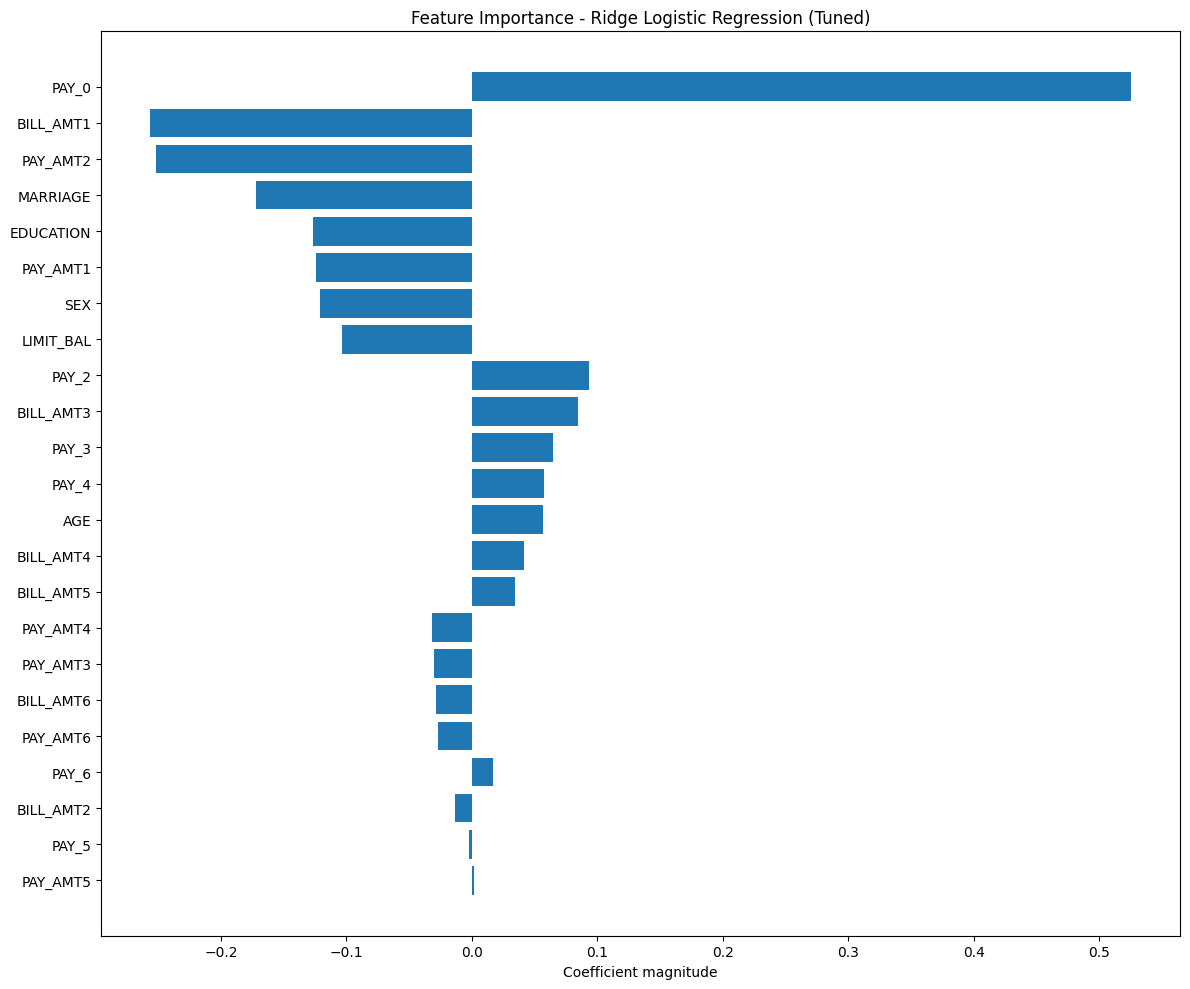


Training Lasso Logistic Regression with Hyperparameter Tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 1.0, 'class_weight': 'balanced'}
Best CV score: 0.7255

Lasso Logistic Regression (Tuned) Results:
Training time: 0.85 seconds
CV ROC-AUC Scores: [0.74530507 0.72345971 0.71450467 0.71505346 0.72940401]
Mean CV ROC-AUC: 0.7255 (±0.0113)
Validation ROC-AUC: 0.7035
Validation Avg Precision: 0.4760

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      4673
           1       0.38      0.61      0.46      1327

    accuracy                           0.69      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.69      0.71      6000


Confusion Matrix:
[[3330 1343]
 [ 521  806]]


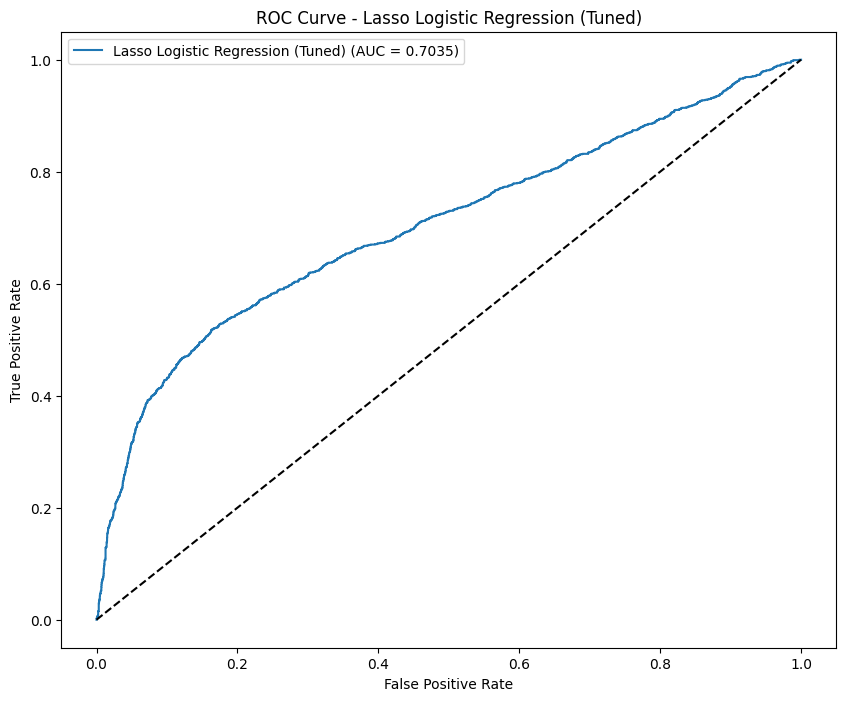

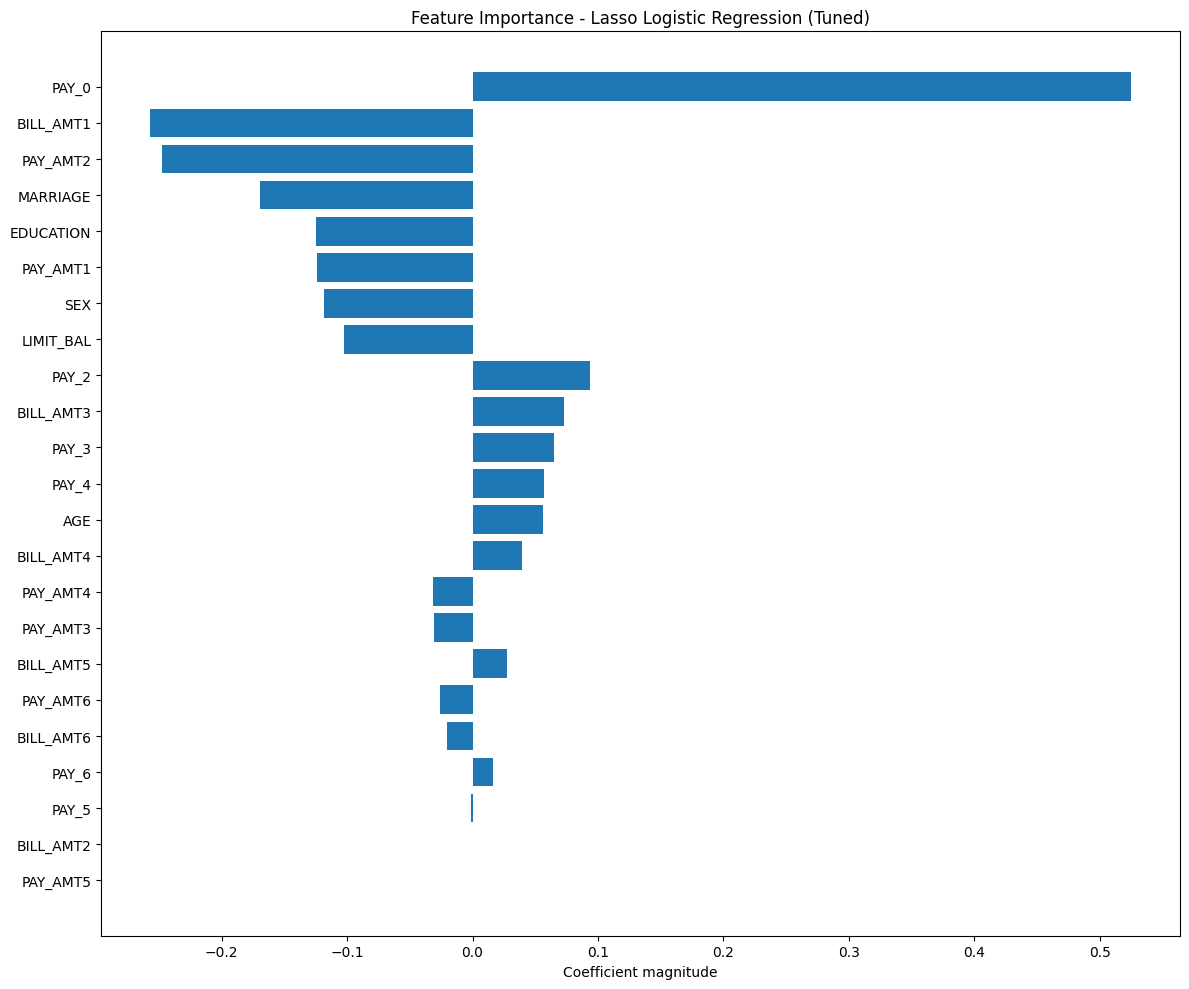


Training Elastic Net Logistic Regression with Hyperparameter Tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1.0, 'l1_ratio': 0.8}
Best CV score: 0.7251

Elastic Net Logistic Regression (Tuned) Results:
Training time: 5.32 seconds
CV ROC-AUC Scores: [0.7442979  0.72304976 0.71376542 0.71552347 0.72868825]
Mean CV ROC-AUC: 0.7251 (±0.0110)
Validation ROC-AUC: 0.7029
Validation Avg Precision: 0.4784

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4673
           1       0.66      0.23      0.34      1327

    accuracy                           0.80      6000
   macro avg       0.74      0.60      0.61      6000
weighted avg       0.78      0.80      0.76      6000


Confusion Matrix:
[[4519  154]
 [1028  299]]


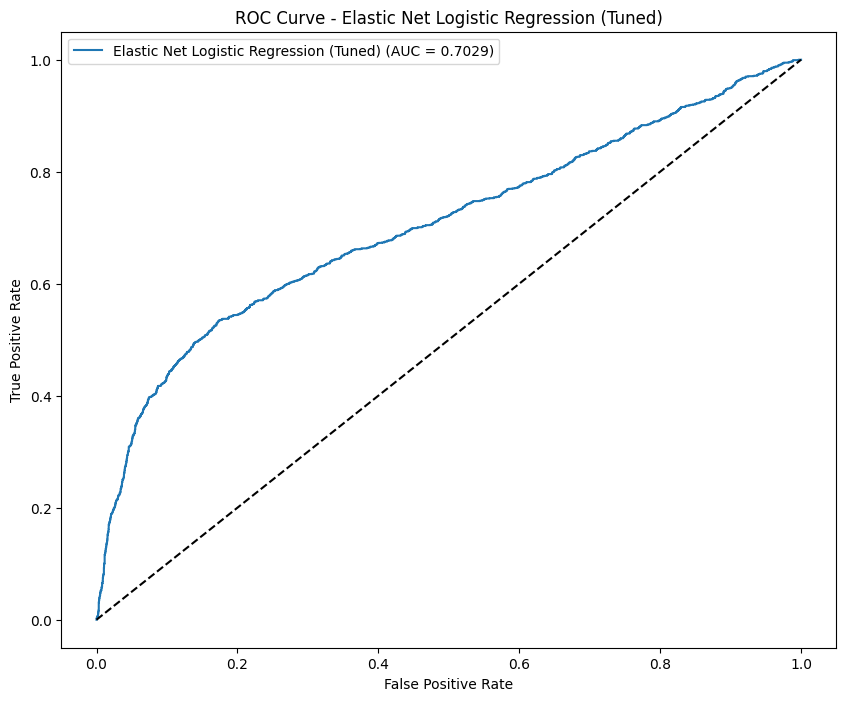

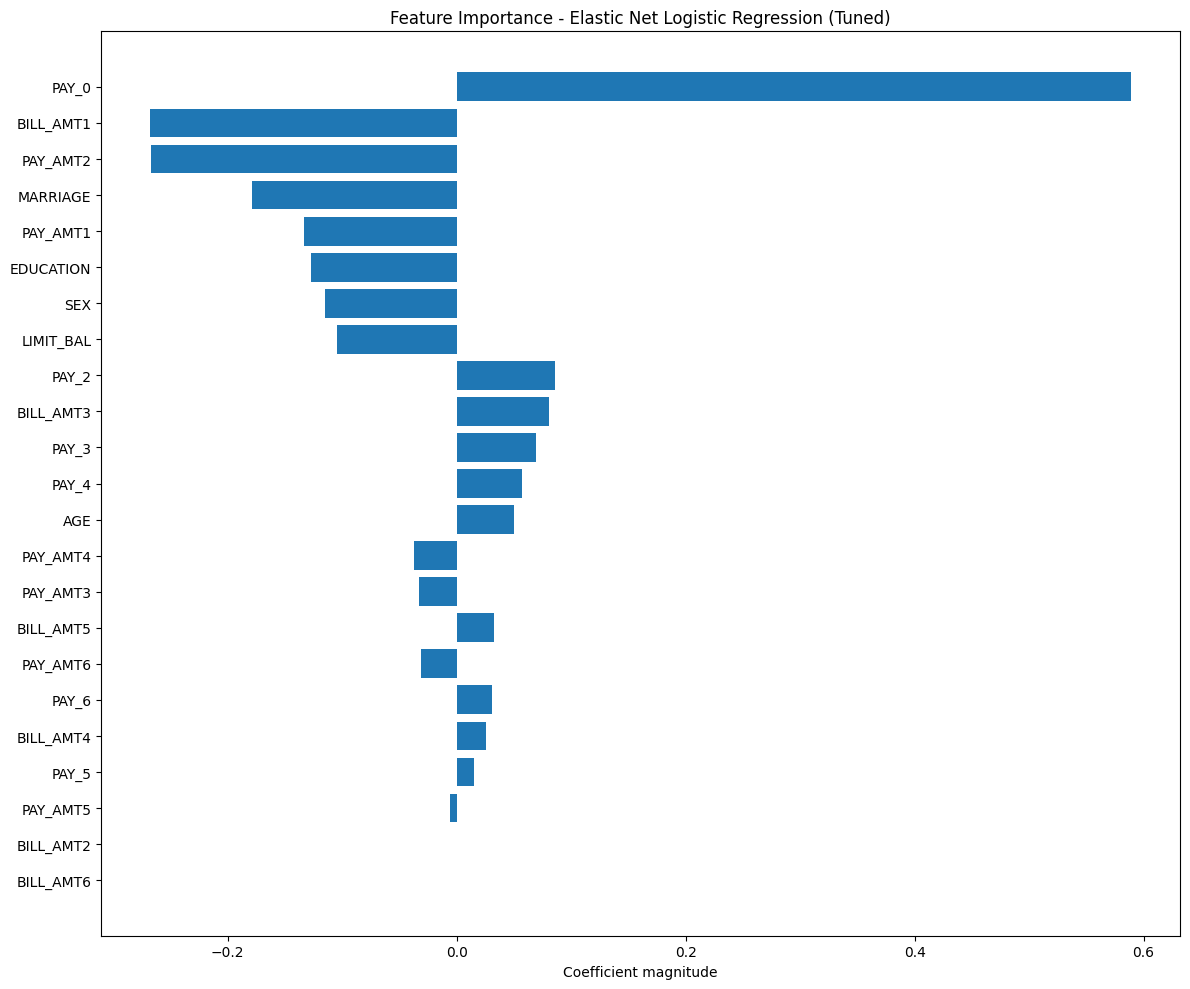


Training Forward Selection with Logistic Regression...
Selected features (Forward): ['LIMIT_BAL', 'SEX', 'PAY_0', 'PAY_3', 'PAY_4', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

Forward Selection Results:
Training time: 0.09 seconds
CV ROC-AUC Scores: [0.74172888 0.72705293 0.71696639 0.7183234  0.73335322]
Mean CV ROC-AUC: 0.7275 (±0.0093)
Validation ROC-AUC: 0.7071
Validation Avg Precision: 0.4791

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.68      0.23      0.34      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.61      6000
weighted avg       0.79      0.81      0.77      6000


Confusion Matrix:
[[4532  141]
 [1024  303]]


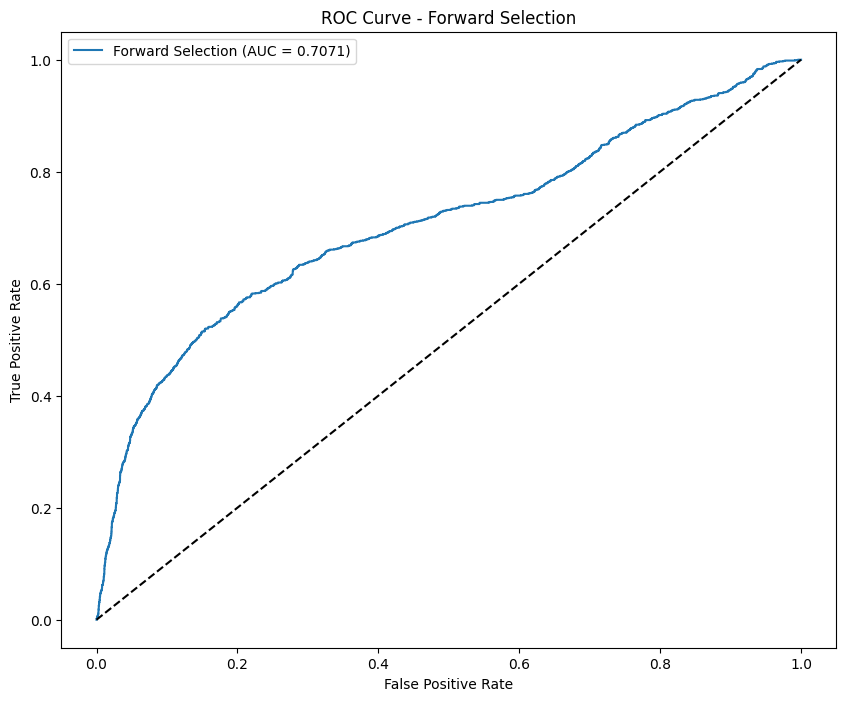

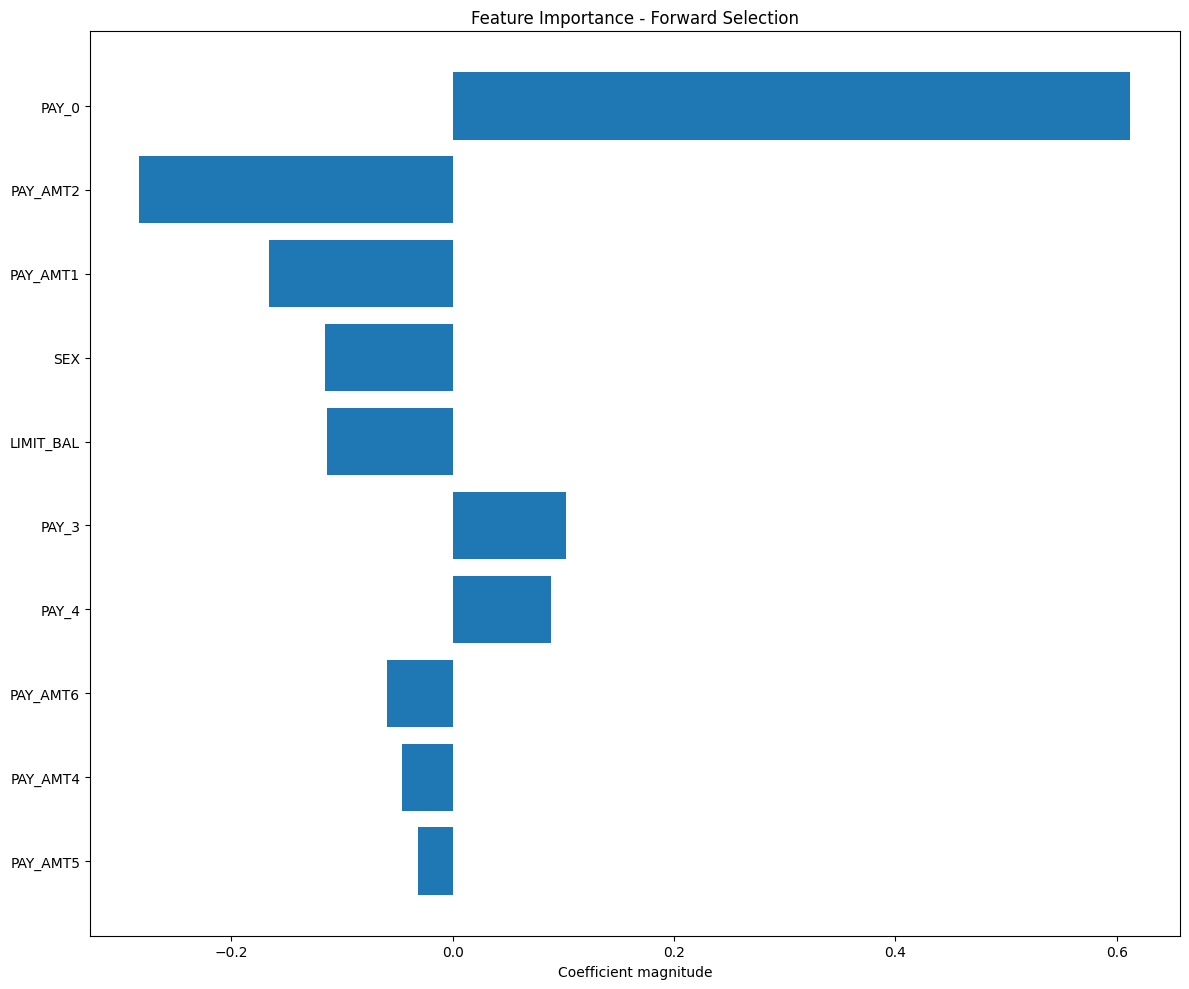


Training Recursive Feature Elimination with Logistic Regression...
Selected features (RFE): ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_4', 'BILL_AMT1', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2']

RFE Selection Results:
Training time: 0.13 seconds
CV ROC-AUC Scores: [0.74001091 0.72216736 0.7110555  0.71160224 0.72666944]
Mean CV ROC-AUC: 0.7223 (±0.0107)
Validation ROC-AUC: 0.7002
Validation Avg Precision: 0.4746

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4673
           1       0.66      0.22      0.33      1327

    accuracy                           0.80      6000
   macro avg       0.74      0.60      0.61      6000
weighted avg       0.78      0.80      0.76      6000


Confusion Matrix:
[[4520  153]
 [1030  297]]


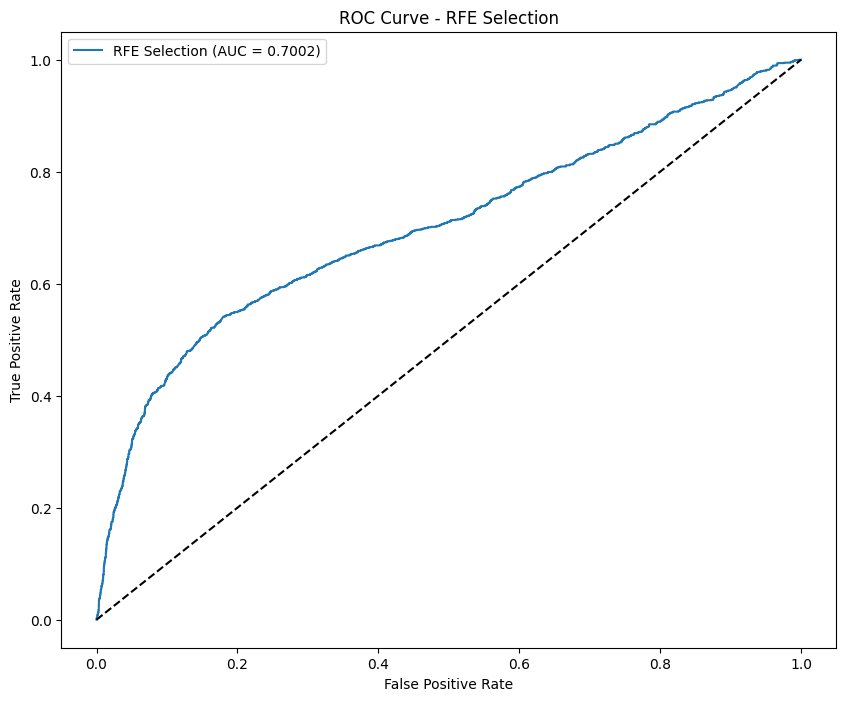

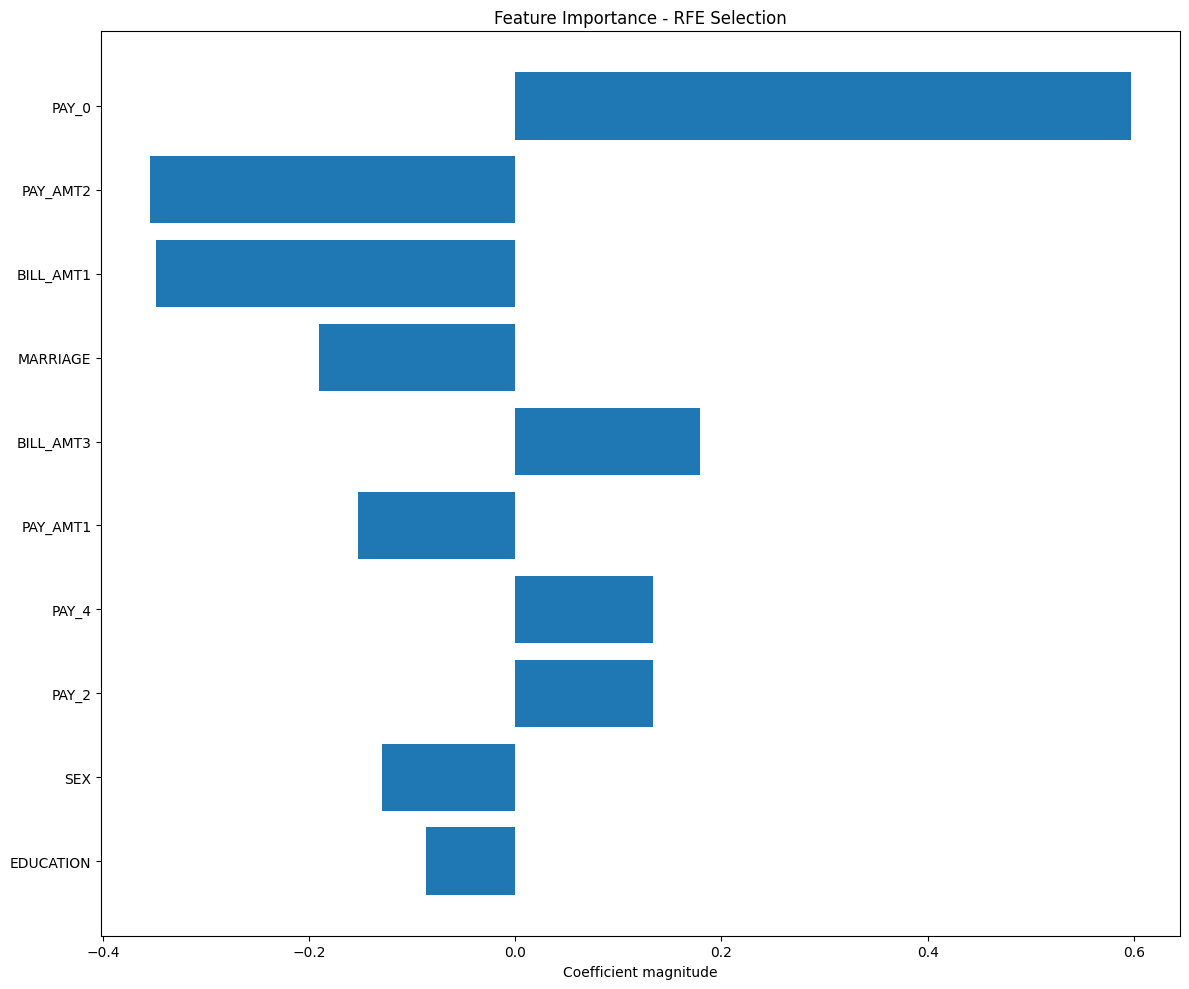


==== Model Comparison and Best Model Selection ====

Models ranked by ROC-AUC performance:
1. Forward Selection: ROC-AUC = 0.7071, Avg Precision = 0.4791
2. Lasso Logistic Regression (Tuned): ROC-AUC = 0.7035, Avg Precision = 0.4760
3. Ridge Logistic Regression (Tuned): ROC-AUC = 0.7034, Avg Precision = 0.4759
4. Baseline Logistic Regression: ROC-AUC = 0.7030, Avg Precision = 0.4785
5. Elastic Net Logistic Regression (Tuned): ROC-AUC = 0.7029, Avg Precision = 0.4784
6. RFE Selection: ROC-AUC = 0.7002, Avg Precision = 0.4746

==== Best Model: Forward Selection with ROC-AUC 0.7071 ====


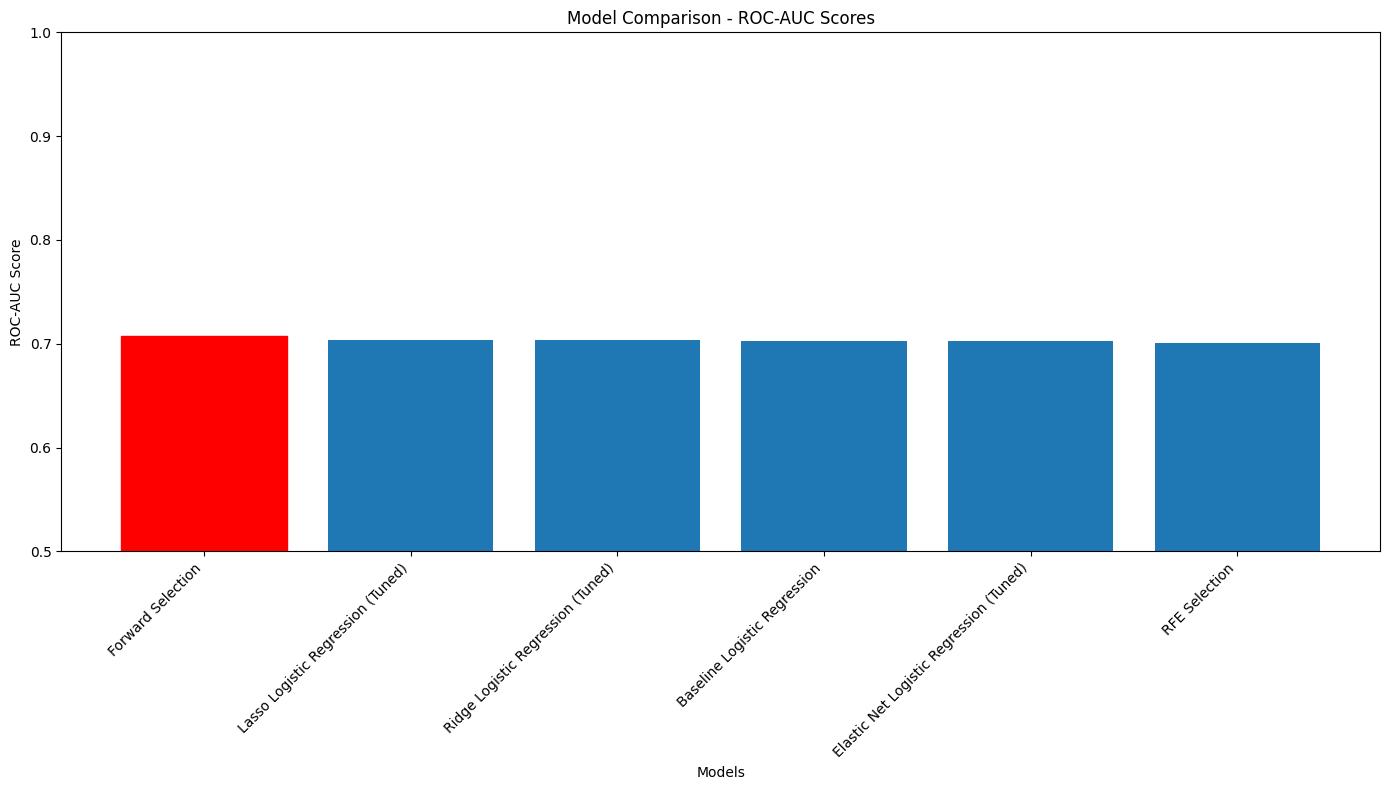


==== Final Evaluation on Test Set ====

Using 10 selected features for final evaluation

Forward Selection (Test) Results:
Training time: 0.09 seconds
CV ROC-AUC Scores: [0.74172888 0.72705293 0.71696639 0.7183234  0.73335322]
Mean CV ROC-AUC: 0.7275 (±0.0093)
Validation ROC-AUC: 0.7268
Validation Avg Precision: 0.5156

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.73      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.77      0.61      0.62      6000
weighted avg       0.80      0.81      0.77      6000


Confusion Matrix:
[[4554  119]
 [1010  317]]


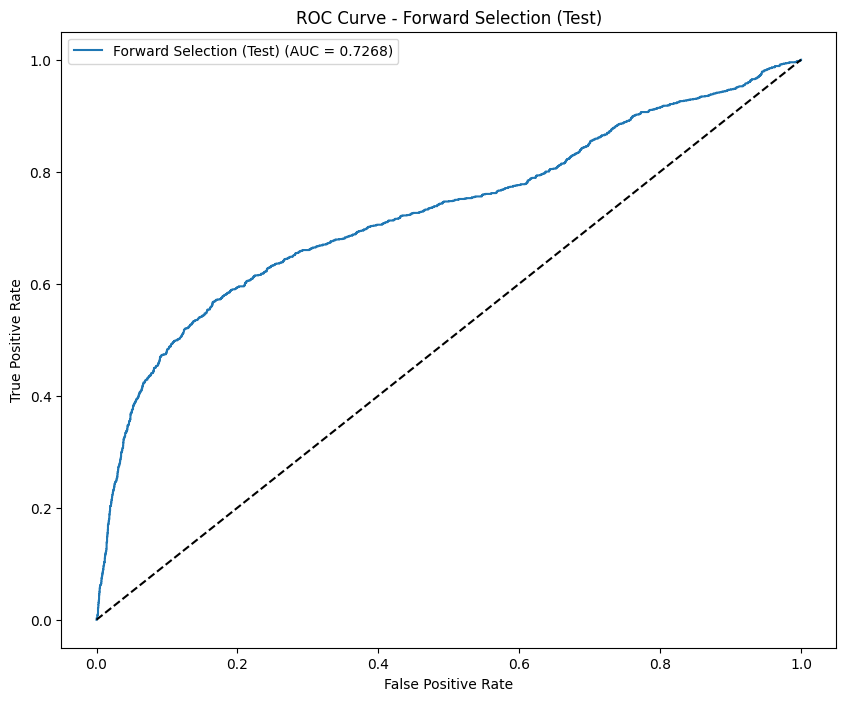

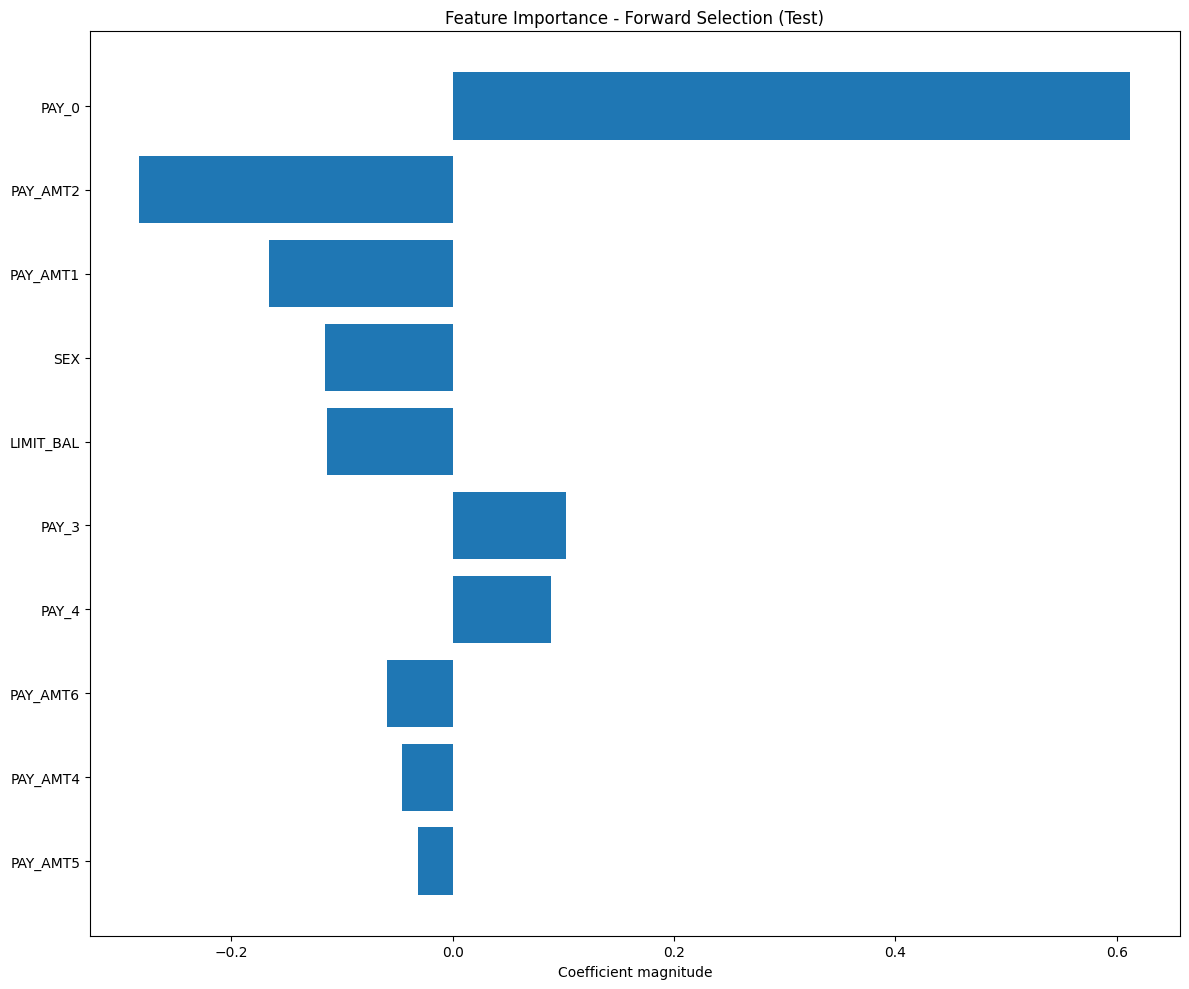


Analysis complete. All results and visualizations are displayed above.


In [3]:
print("\n==== Model Building and Evaluation ====")

# Dictionary to store models and their performance
models = {}

# 1. Baseline Logistic Regression
print("\nTraining baseline Logistic Regression...")
baseline_model = LogisticRegression(random_state=42, max_iter=2000)
models['Baseline Logistic Regression'] = evaluate_model(baseline_model, X_train, y_train, X_val, y_val, "Baseline Logistic Regression")

# 2. Ridge Logistic Regression (L2 regularization) with hyperparameter tuning
print("\nTraining Ridge Logistic Regression with Hyperparameter Tuning...")
ridge_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced']
}
ridge_base = LogisticRegression(penalty='l2', random_state=42, max_iter=2000)
ridge_tuned = tune_hyperparameters(ridge_base, ridge_param_grid, X_train, y_train)
models['Ridge Logistic Regression (Tuned)'] = evaluate_model(ridge_tuned, X_train, y_train, X_val, y_val, "Ridge Logistic Regression (Tuned)")

# 3. Lasso Logistic Regression (L1 regularization) with hyperparameter tuning
print("\nTraining Lasso Logistic Regression with Hyperparameter Tuning...")
lasso_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced']
}
lasso_base = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=2000)
lasso_tuned = tune_hyperparameters(lasso_base, lasso_param_grid, X_train, y_train)
models['Lasso Logistic Regression (Tuned)'] = evaluate_model(lasso_tuned, X_train, y_train, X_val, y_val, "Lasso Logistic Regression (Tuned)")

# 4. Elastic Net Logistic Regression (L1 + L2 regularization) with hyperparameter tuning
print("\nTraining Elastic Net Logistic Regression with Hyperparameter Tuning...")
elastic_net_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.2, 0.5, 0.8]
}
elastic_net_base = LogisticRegression(penalty='elasticnet', solver='saga', random_state=42, max_iter=2000)
elastic_net_tuned = tune_hyperparameters(elastic_net_base, elastic_net_param_grid, X_train, y_train)
models['Elastic Net Logistic Regression (Tuned)'] = evaluate_model(elastic_net_tuned, X_train, y_train, X_val, y_val, "Elastic Net Logistic Regression (Tuned)")

# 5. Forward Selection
print("\nTraining Forward Selection with Logistic Regression...")
forward_selector = SequentialFeatureSelector(
    LogisticRegression(random_state=42, max_iter=2000),
    n_features_to_select=10,
    direction='forward',
    scoring='roc_auc',
    cv=3
)
forward_selector.fit(X_train, y_train)
forward_features = X_train.columns[forward_selector.get_support()]
print(f"Selected features (Forward): {forward_features.tolist()}")

forward_model = LogisticRegression(random_state=42, max_iter=2000)
models['Forward Selection'] = evaluate_model(forward_model, X_train, y_train, X_val, y_val, "Forward Selection", forward_features)

# 6. Recursive Feature Elimination (RFE)
print("\nTraining Recursive Feature Elimination with Logistic Regression...")
rfe = RFE(
    estimator=LogisticRegression(random_state=42, max_iter=2000),
    n_features_to_select=10,
    step=1
)
rfe.fit(X_train, y_train)
rfe_features = X_train.columns[rfe.get_support()]
print(f"Selected features (RFE): {rfe_features.tolist()}")

rfe_model = LogisticRegression(random_state=42, max_iter=2000)
models['RFE Selection'] = evaluate_model(rfe_model, X_train, y_train, X_val, y_val, "RFE Selection", rfe_features)

print("\n==== Model Comparison and Best Model Selection ====")
model_names = list(models.keys())
avg_precision_scores = [models[model][0] for model in model_names]
roc_auc_scores = [models[model][1] for model in model_names]

# Sort models by ROC-AUC performance in descending order
sorted_indices = np.argsort(roc_auc_scores)[::-1]
sorted_models = [model_names[i] for i in sorted_indices]
sorted_auc = [roc_auc_scores[i] for i in sorted_indices]
sorted_ap = [avg_precision_scores[i] for i in sorted_indices]

best_model_name = sorted_models[0]
best_auc = sorted_auc[0]
best_model = models[best_model_name][2]

print("\nModels ranked by ROC-AUC performance:")
for i, (model, auc, ap) in enumerate(zip(sorted_models, sorted_auc, sorted_ap)):
    print(f"{i+1}. {model}: ROC-AUC = {auc:.4f}, Avg Precision = {ap:.4f}")

print(f"\n==== Best Model: {best_model_name} with ROC-AUC {best_auc:.4f} ====")

# Plot comparison chart for all models
plt.figure(figsize=(14, 8))
bars = plt.bar(sorted_models, sorted_auc)
plt.title('Model Comparison - ROC-AUC Scores')
plt.xlabel('Models')
plt.ylabel('ROC-AUC Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha='right')
bars[0].set_color('red')  # Highlight best model
plt.tight_layout()
plt.show()

print("\n==== Final Evaluation on Test Set ====")

# Determine which features to use for the best model (if applicable)
selected_features = None
if best_model_name == 'Forward Selection':
    selected_features = forward_features
elif best_model_name == 'RFE Selection':
    selected_features = rfe_features

# Evaluate best model on the test set
if selected_features is not None:
    print(f"\nUsing {len(selected_features)} selected features for final evaluation")
    final_ap, final_auc, _ = evaluate_model(best_model, X_train, y_train, X_test, y_test, f"{best_model_name} (Test)", selected_features)
else:
    final_ap, final_auc, _ = evaluate_model(best_model, X_train, y_train, X_test, y_test, f"{best_model_name} (Test)")

# Save the best model (if needed, can be commented out if not required)
# joblib.dump(best_model, 'best_model.pkl')

print("\nAnalysis complete. All results and visualizations are displayed above.")


**Result Analysis**

Baseline vs. Penalized Models:
The baseline logistic regression achieved a validation ROC‑AUC of about 0.7030 with a strong performance on non‑default cases (class 0) but much lower recall for defaults (class 1). The penalized methods (Ridge, Lasso, and Elastic Net) produced nearly identical CV and validation scores (ROC‑AUC around 0.703–0.704) with only minimal improvements in average precision. This suggests that—in this case—the regularization did not yield dramatic gains over the unpenalized model.

Subset Selection – Forward Selection:
The forward selection approach, which used a reduced set of 10 features, achieved a slightly higher validation ROC‑AUC (0.7071) and, in the final test evaluation, maintained a mean CV ROC‑AUC of 0.7275 and a validation ROC‑AUC of 0.7268. Although the improvements are modest, the subset model shows that carefully selecting a few key predictors (such as LIMIT_BAL, SEX, PAY_0, PAY_3, PAY_4, and several PAY_AMT features) can slightly boost performance and may simplify model interpretation.

Other Feature Selection (RFE):
The recursive feature elimination (RFE) approach selected a different set of 10 features and produced a lower validation ROC‑AUC of 0.7002. This indicates that, for this dataset, forward selection identified a more useful subset than RFE, which may have omitted or misweighted some critical variables.

Classification Performance & Imbalance:
Across models, the confusion matrices and classification reports reveal that while non‑defaults (class 0) are well‑classified, defaults (class 1) suffer from low recall. For instance, the forward selection model on the test set achieves a recall of only 0.24 for defaults despite a higher precision (0.73). This imbalance indicates that while the models are conservative in predicting defaults (avoiding false positives), they are missing many actual default cases. This trade‑off might require further investigation—perhaps through adjusting the decision threshold or exploring cost‑sensitive learning—if the cost of missing defaults is high.

Overall Model Comparison:

The forward selection model ranks highest in terms of ROC‑AUC (0.7071 on the validation set and 0.7268 on the final test evaluation), suggesting it offers the best discriminatory power among the approaches tried.

Penalized models and the baseline logistic regression all hover around similar performance levels, indicating that the extra complexity of regularization did not translate into significant improvements for this dataset.

In summary, the analysis shows that while all models perform similarly in terms of average ROC‑AUC, the forward selection method’s slight edge and interpretability make it a preferred choice. However, the consistent challenge across all approaches is the low recall for the default class, which indicates that future work could focus on addressing class imbalance or exploring alternative modeling strategies to improve detection of defaults.





